# Información sobre el dataset
Los pagos electrónicas están evolucionando, pero también lo están los criminales en línea. Acorde al índice de Data Breach, más de 5 millones de registros han sido robados diariamente, una estadística alarmante. que muestra - los fraudes son todavía muy comunes tanto para pagos con tarjetas físicas como digitales.  
Por lo que la detección de fraudes es todo un desafío actualmente.  
El siguiente dataset fue conseguido de la página de kaggle [Credit Card Fraud](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud), el cuál contiene la siguiente información:  
1. distance_from_home: Distancia entre el lugar donde se realizó la transacción y la dirección registrada como "hogar" del titular de la tarjeta.
2. distance_from_last_transaction: Distancia entre la ubicación de esta transacción y la ubicación donde ocurrió la transacción anterior.
3. ratio_to_median_purchase_price: Relación entre el valor de esta compra y el valor medio de compras anteriores del mismo usuario.
4. repeat_retailer: Indica si esta transacción fue realizada en un comercio ya frecuentado por el titular de la tarjeta. (1 = sí, 0 = no)
5. used_chip: Indica si la transacción se realizó utilizando el chip de la tarjeta. (1 = sí, 0 = no)
6. used_pin_number: Indica si se utilizó un número PIN durante la transacción. (1 = sí, 0 = no)
7. online_order: Indica si la transacción fue realizada en línea. (1 = sí, 0 = no)
8. fraud: Etiqueta binaria que indica si la transacción fue fraudulenta. (1 = sí, 0 = no)

# Importar librerías necesarias

In [5]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de evaluación
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelado
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV


# Cargar datos

In [6]:
df = pd.read_csv('../data/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


# Exploración de datos
Analizaremos el balanceo de clases, es decir, cómo es la proporcionalidad de las clases a predecir. Lo que me interesa es ver cuántos datos hay de cada clase 

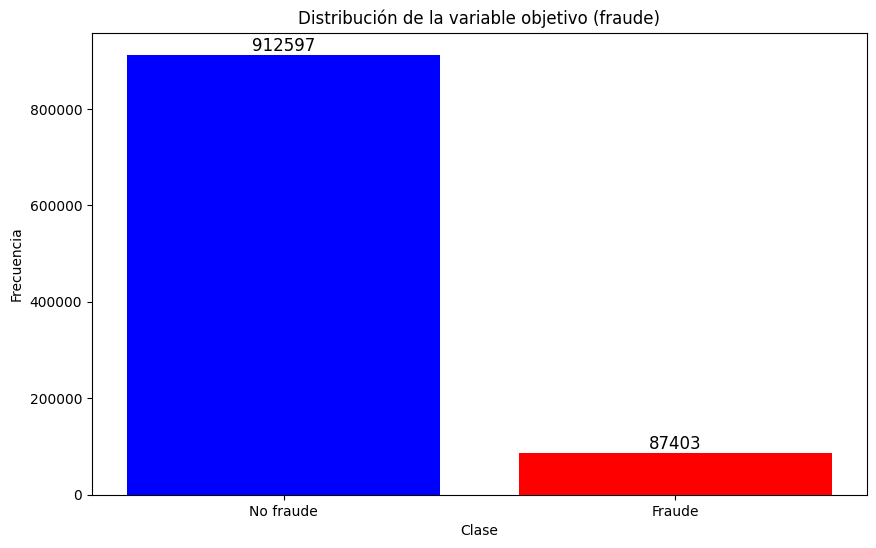

In [8]:
plt.figure(figsize=(10, 6))
conteo = df["fraud"].value_counts()
plt.bar(conteo.index, conteo.values, color=["blue", "red"])
plt.title("Distribución de la variable objetivo (fraude)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks([0,1], ["No fraude", "Fraude"])
for clase, valor in enumerate(conteo.values):
    plt.text(clase, valor + 50, str(valor), ha = "center", va = "bottom", fontsize = 12)
plt.savefig("../figures/Desbalance_clases.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
porcentajes_clases = df["fraud"].value_counts().values/len(df)
print(f"Porcentaje de clase 0: {porcentajes_clases[0]*100:.2f}%")
print(f"Porcentaje de clase 1: {porcentajes_clases[1]*100:.2f}%")

Porcentaje de clase 0: 91.26%
Porcentaje de clase 1: 8.74%


Podemos notar que existe un desbalance de clases, lo que puede afectar al entrenamiento del modelo, así como también puede afectar a la interpretabilidad de las métricas.  
Más adelante en este notebook se hablará de cómo resolver el desbalanceo de clases. Por ahora seguiremos explorando los datos y su distribuciones.

In [10]:
df.nunique()

distance_from_home                1000000
distance_from_last_transaction    1000000
ratio_to_median_purchase_price    1000000
repeat_retailer                         2
used_chip                               2
used_pin_number                         2
online_order                            2
fraud                                   2
dtype: int64

Las columnas ["distance_from_home"], ["distance_from_last_transaction"] y ["ratio_to_median_purchase_price"] con variables continuas, mientras que las demás son variables categóricas, así que graficaré la distribución de las variables continuas

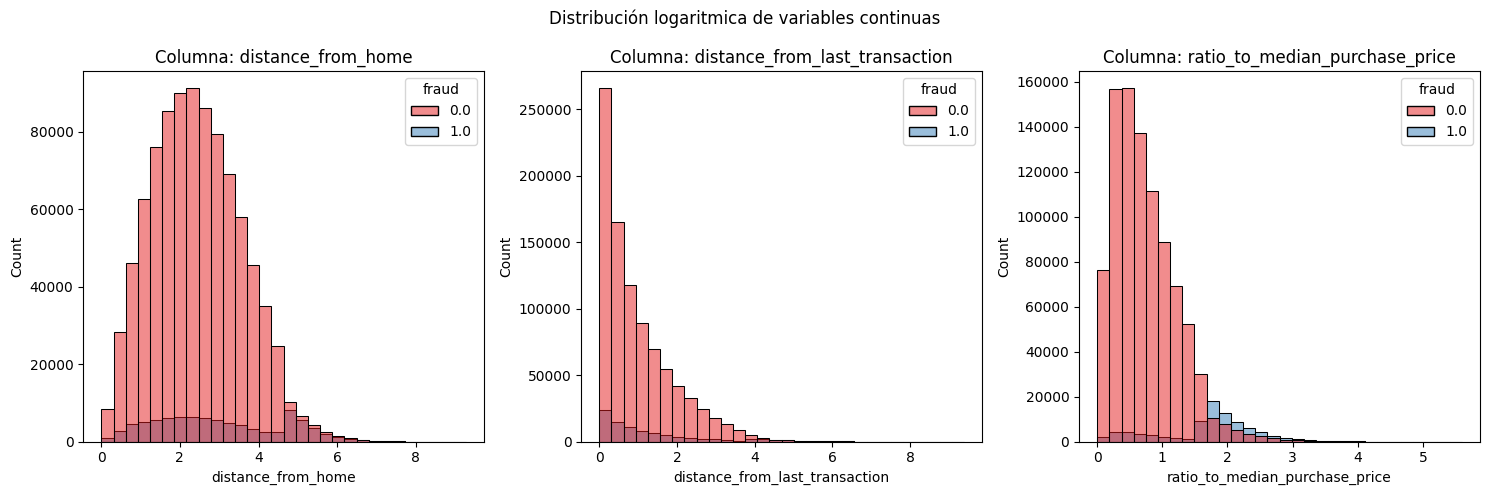

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    x = np.log(df[df.columns[i]] + 1)
    sns.histplot(data = df, x= x, hue = "fraud", ax = axes[i], bins = 30, palette = "Set1", alpha = 0.5)
    axes[i].set_title(f"Columna: {df.columns[i]}")
plt.suptitle("Distribución logaritmica de variables continuas")
plt.savefig("../figures/Distribucion_variables_continuas.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

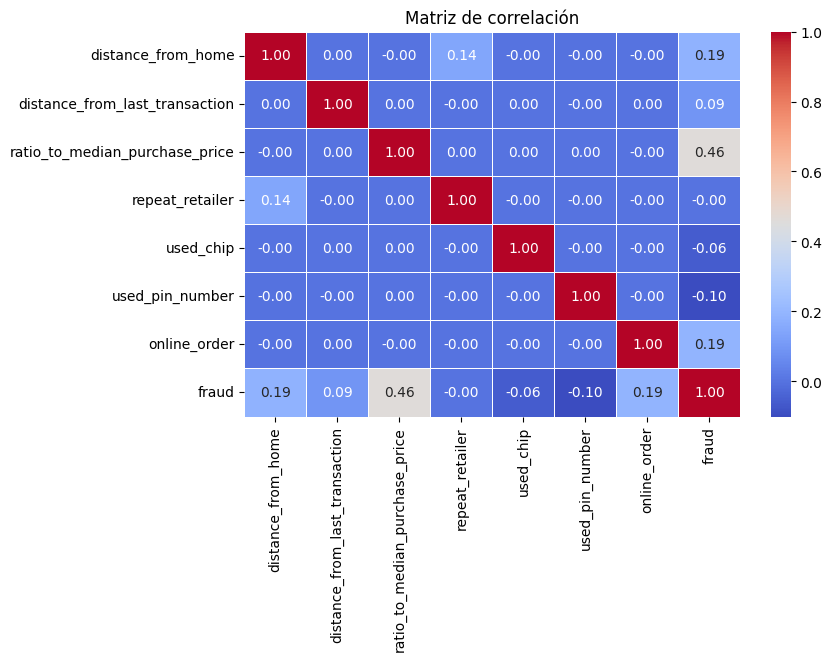

In [12]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5)
plt.title("Matriz de correlación")
plt.savefig("../figures/Correlacion_variables.png", dpi=300, bbox_inches="tight")
plt.show()

Podemos notar en la matriz de correlación que sólo la columna "fraud" tiene cierta relación lineal con las demás columas, mientras que casi no hay ninguna relación lineal entre las demás columnas. 
Antes de pasar al modelado, haré algunas transformaciones a las columnas y corroboraré si hay cambios en la matriz de correlación.

## Feature Engineering
Para las variables continuas, las reemplazaré por su valor logarítmico base 10 y despues estandarizaré las distribuciones.

In [13]:
# Para las primeras 3 columnas que son las variables continuas
for i in range(3):
    # Aplicamos la transformación logarítmica a las variables continuas
    df[df.columns[i]] = np.log10(df[df.columns[i]] + 1)
    # Normalizamos las variables continuas
    df[df.columns[i]] = (df[df.columns[i]] - df[df.columns[i]].mean()) / df[df.columns[i]].std()
df.sample(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
340012,-0.861205,-0.898157,4.591979,1.0,0.0,0.0,1.0,1.0
138710,0.103692,-0.991941,-1.232124,1.0,0.0,0.0,0.0,0.0
185845,2.308298,-0.896385,-0.224620,1.0,0.0,1.0,0.0,0.0
24714,2.407277,-0.076430,0.359070,1.0,0.0,0.0,0.0,0.0
987915,0.306133,-0.675293,0.065666,1.0,0.0,0.0,1.0,0.0


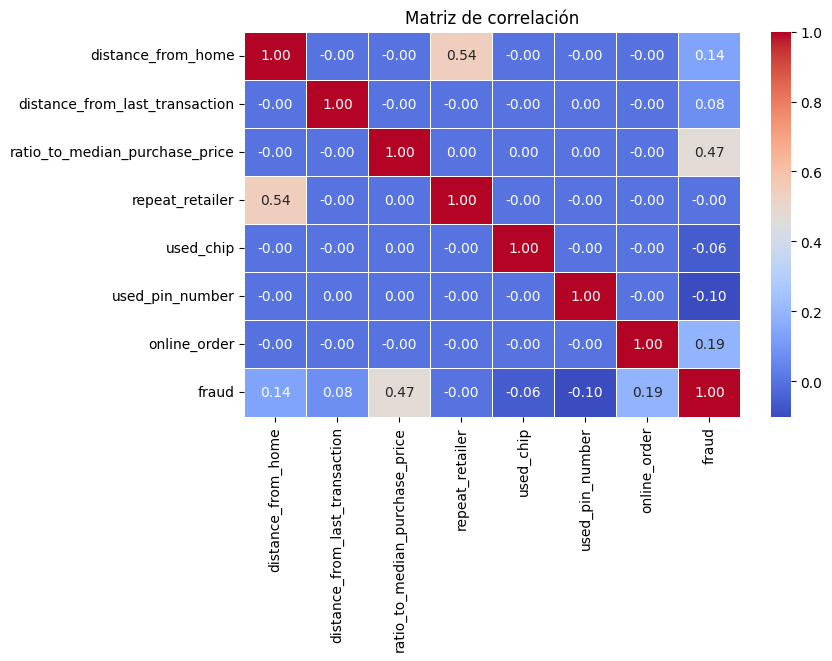

In [14]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5)
plt.title("Matriz de correlación")
plt.savefig("../figures/Correlacion_variables_logaritmos.png", dpi=300, bbox_inches="tight")
plt.show()

Al parecer no hubo un gran cambio. Las propiedades lineales se quedaron casi iguales.  
Aún así se usaran estos cambios para el entrenamiento del modelo.

# Separación de datos en entrenamiento y prueba

In [15]:
y = df.iloc[:,-1]
X = df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 14)

# Entrenamiento de modelos
## Autoencoders
Los autoencoders son una técnica de aprendizaje no supervisado que se utiliza para la detección de anomalías.
La idea básica detrás de un autoencoder es que se entrena una red neuronal para reconstruir sus entradas. Durante el entrenamiento, la red aprende a comprimir la información de entrada en un espacio latente y luego a reconstruirla. Si la red es capaz de reconstruir bien las entradas normales, pero falla al hacerlo con entradas anómalas, podemos usar esta propiedad para detectar anomalías.  
Se usará un autoencoder para detectar las transacciones fraudulentas.  
Para el modelo autoencoder se separarán los datos de entrenamiento y prueba en fraude y no fraude para poder entrenar el modelo sólo con datos no fraudulentos y pueda distinguir entre datos anormales, que en este caso serían los fraudulentos.

In [16]:
no_fraude_x_train = X_train[y_train == 0]
fraude_x_train = X_train[y_train == 1]

no_fraude_x_test = X_test[y_test == 0]
fraude_x_test = X_test[y_test == 1]

In [17]:
latent_dim = 2
input_dim = no_fraude_x_test.shape[1]
print(f"Dimensión de entrada: {input_dim}")

Dimensión de entrada: 7


In [18]:
# Creando el modelo autoencoder
encoder = Sequential()
encoder.add(Input(shape = (input_dim,)))
encoder.add(Dense(8, activation = "relu"))
encoder.add(BatchNormalization())
encoder.add(Dense(4, activation = "relu"))
encoder.add(BatchNormalization())
encoder.add(Dense(latent_dim, activation = "relu")) # Capa latente

decoded = Sequential()
decoded.add(Input(shape = (latent_dim,)))
decoded.add(Dense(4, activation = "relu"))
decoded.add(BatchNormalization())
decoded.add(Dense(8, activation = "relu"))
decoded.add(BatchNormalization())
decoded.add(Dense(input_dim, activation= "sigmoid")) # Capa de salida

# Conectando el encoder y el decoder
autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoded)
autoencoder.compile(optimizer = Adam(learning_rate = 0.0005), loss = "mse")

encoder.summary()
decoded.summary()
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158 (632.00 B)

 Trainable params: 134 (536.00 B)

 Non-trainable params: 24 (96.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163 (652.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 24 (96.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 2)              │           158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 7)              │           163 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 48 (192.00 B)

### Entrenamiento del autoencoder

In [19]:
history = autoencoder.fit(
    no_fraude_x_train, no_fraude_x_train,
    epochs = 10,
    batch_size = 256,
    validation_data = (no_fraude_x_test, no_fraude_x_test),
    shuffle = True 
)

Epoch 1/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.4668 - val_loss: 0.2939
Epoch 2/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2898 - val_loss: 0.2811
Epoch 3/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2813 - val_loss: 0.2755
Epoch 4/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2740 - val_loss: 0.2702
Epoch 5/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.2712 - val_loss: 0.2671
Epoch 6/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2683 - val_loss: 0.2660
Epoch 7/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2677 - val_loss: 0.2661
Epoch 8/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2678 - val_loss: 0.2654
Epoch 9/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2661 - val_loss: 0.2645
Epoch 10/10
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2649 - val_loss: 0.2637


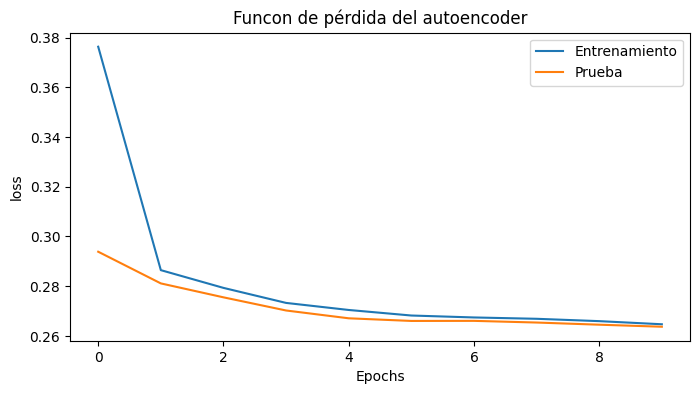

In [20]:
plt.figure(figsize= (8, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Funcon de pérdida del autoencoder')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("../figures/Funcion_perdida.png", dpi=300, bbox_inches="tight")
plt.show()

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 688us/step


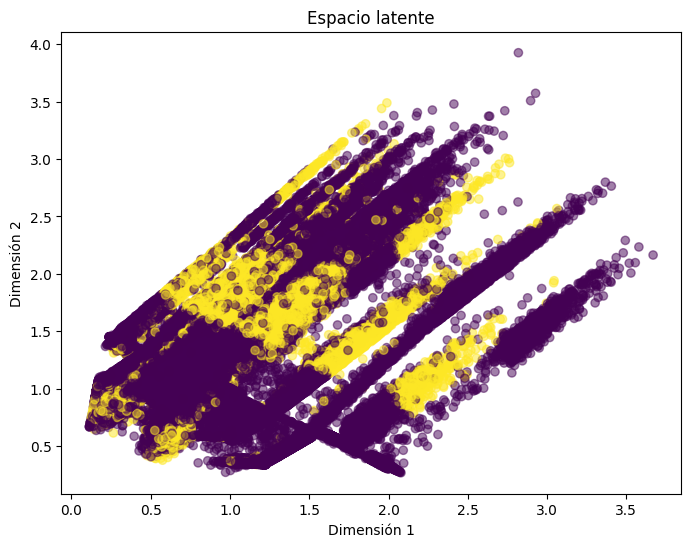

In [21]:
espacio_latente = encoder.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(espacio_latente[:, 0], espacio_latente[:, 1], c = y_test, alpha = 0.5)
plt.title("Espacio latente")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.savefig("../figures/espacio_latente.png", dpi=300, bbox_inches="tight")
plt.show()

Visualizaremos las distribuciones de los errores para cada clase y así ver si el modelo es capaz de distinguir entre las transacciones fraudulentas y no fraudulentas.
### Predicción de datos de prueba

In [22]:
no_fraude_pred = autoencoder.predict(no_fraude_x_test)
mse_no_fraude = np.mean(no_fraude_pred - no_fraude_x_test, axis= 1)

fraude_pred = autoencoder.predict(fraude_x_test)
mse_fraude = np.mean(fraude_pred - fraude_x_test, axis=1)

5703/5703 ━━━━━━━━━━━━━━━━━━━━ 5s 822us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


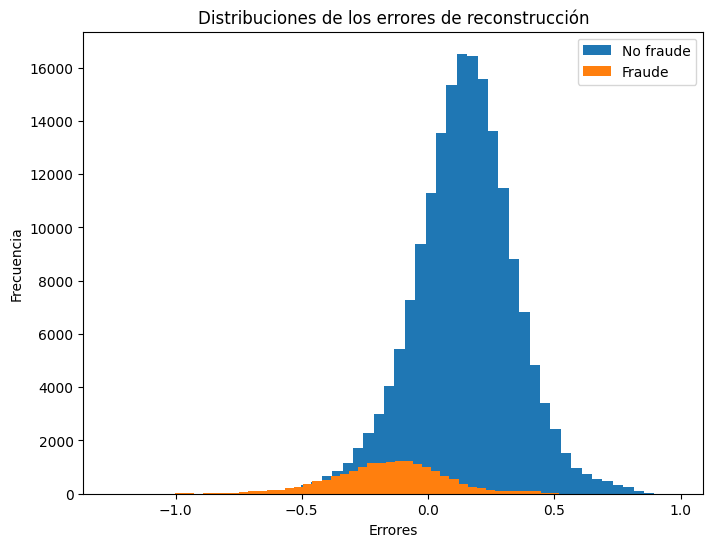

In [23]:
plt.figure(figsize = (8,6))
plt.hist(mse_no_fraude, bins=50, label = "No fraude")
plt.hist(mse_fraude, bins=50, label="Fraude")
plt.legend()
plt.title("Distribuciones de los errores de reconstrucción")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.savefig("../figures/Errores_reconstruccion.png", dpi=300, bbox_inches="tight")
plt.show()

Podemos notar que las distribuciones de los errores no son tan diferentes, pero para tener una medición de la efectividad del modelo, se usará obtendrá un umbral de decisión para clasificar las transacciones como fraudulentas o no fraudulentas.
Cabe aclarar que para este caso se optó por usar el error promedio en lugar del error cuadrático medio ya que las distribuciones se sobreponían aún más.
### Evaluación del modelo

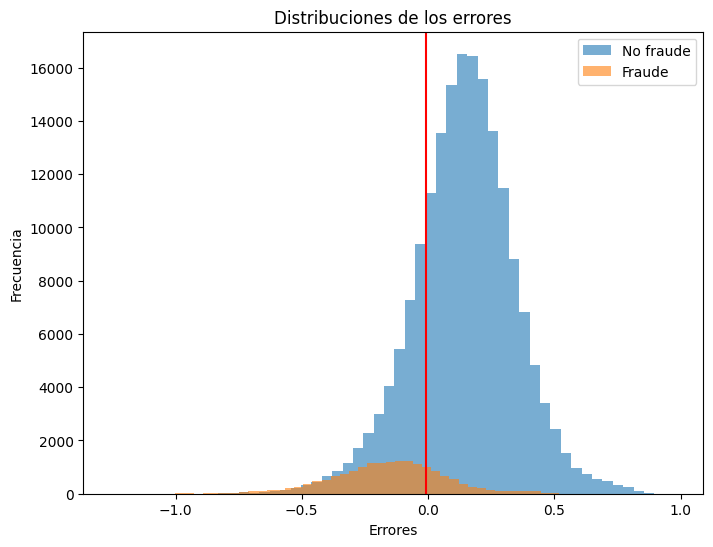

In [24]:
# Calcular los histogramas
hist_no_fraude, bins_no_fraude = np.histogram(mse_no_fraude, bins=50)
hist_fraude, bins_fraude = np.histogram(mse_fraude, bins=50)
# Encontrar los picos de las distribuciones
max_no_fraude = bins_no_fraude[np.argmax(hist_no_fraude)]
max_fraude = bins_fraude[np.argmax(hist_fraude)]

# Calcular el promedio entre ambos picos
umbral = (max_no_fraude + max_fraude) / 2

# Graficar umbral de decisión entre ambas distribuciones de errores
plt.figure(figsize = (8,6))
plt.hist(mse_no_fraude, bins=50, label = "No fraude", alpha = 0.6)
plt.hist(mse_fraude, bins=50, label="Fraude", alpha= 0.6)
plt.axvline(x=umbral, c = "red")
plt.legend()
plt.title("Distribuciones de los errores")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.savefig("../figures/Umbral_decision.png", dpi=300, bbox_inches="tight")
plt.show()

Teniendo la distribución de los errores y el umbral, podemos etiquetar los datos de prueba como fraudulentos o no fraudulentos.
### Métricas de evaluación

In [25]:
def etiquetar_y_predecir(autoencoder, X_test, y_test, threshold):
    # Obtener las predicciones del autoencoder para los datos de prueba
    predicciones_test = autoencoder.predict(X_test)
    
    # Calcular el error de reconstrucción (MSE) para cada muestra
    mse_test = np.mean(X_test - predicciones_test, axis=1)
    
    # Etiquetar los datos según el umbral
    predicciones = mse_test < threshold # 1 es fraude, 0 no fraude
    
    # Comparar las etiquetas predichas con las etiquetas reales
    etiquetas_reales = y_test == 1 # 1 es fraude, 0 no fraude
    precision = np.mean(predicciones == etiquetas_reales)
    
    return predicciones, precision

# Usar la función con los datos de prueba
predicciones, precision = etiquetar_y_predecir(autoencoder, X_test, y_test, umbral)
print("Precisión de la predicción:", precision)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 831us/step
Precisión de la predicción: 0.229005


Recall: 0.2149


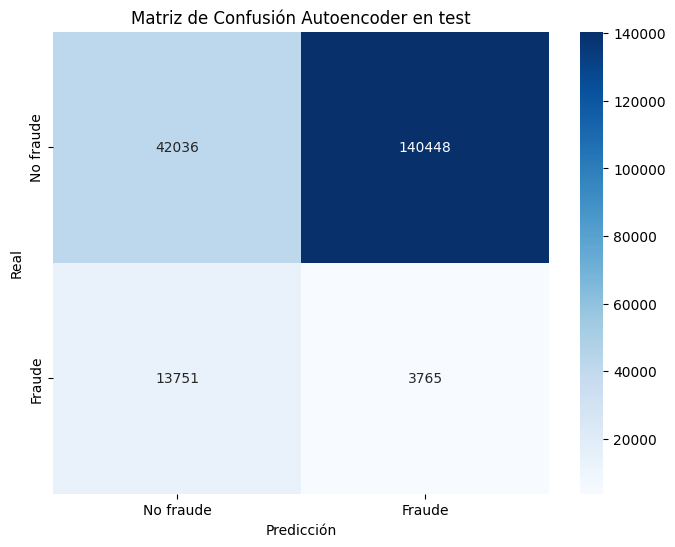

In [26]:

from sklearn.metrics import recall_score
recall = recall_score(y_test, predicciones)
print(f"Recall: {recall:.4f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_test, predicciones)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No fraude", "Fraude"], yticklabels=["No fraude", "Fraude"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Autoencoder en test')
plt.savefig("../figures/Matriz_confusion_autoencoder_test.png", dpi=300, bbox_inches="tight")
plt.show()

Podemos notar que el modelo no tiene un buen desempeño, ya que las métricas de evaluación son muy bajas. Se podría optar por mover el umbral de decisión para mejorar el valor de recall y así obtener más transacciones fraudulentas, pero eso afectaría el valor de precisión y tendriamos más falsos positivos.  
A continuación se probará otro modelo de machine learning más robusto y apto para el desbalanceo de clases el cuál es XGBoost.

## XGBoost
XGBoost es un algoritmo de aprendizaje automático basado en árboles de decisión que ha demostrado ser muy efectivo para tareas de clasificación y regresión.
XGBoost es especialmente útil para conjuntos de datos desbalanceados, ya que tiene varias técnicas incorporadas para manejar este problema, como el ajuste de pesos de las clases y la regularización.

In [27]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(
    n_estimators=1000, # Número de árboles
    learning_rate=0.01, # Tasa de aprendizaje
    max_depth=3, # Profundidad máxima de los árboles
    min_child_weight=1, # Peso mínimo de los hijos
    gamma=0, # Reducción mínima de la pérdida
    subsample=0.8, # Proporción de muestras a usar para cada árbol
    colsample_bytree=0.8, # Proporción de características a usar para cada árbol
    scale_pos_weight=1, # Peso para la clase positiva (fraude)
    random_state=42 # Semilla aleatoria para reproducibilidad
)

In [28]:
# Entrenar el modelo XGBoost
xgboost.fit(X_train, y_train)
# Predecir en el conjunto de prueba
y_pred = xgboost.predict(X_test)
# Calcular la exactitud 
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo XGBoost: {accuracy:.4f}")
# Calcular el recall
recall = recall_score(y_test, y_pred)
print(f"Recall del modelo XGBoost: {recall:.4f}")

Exactitud del modelo XGBoost: 0.9983
Recall del modelo XGBoost: 0.9872


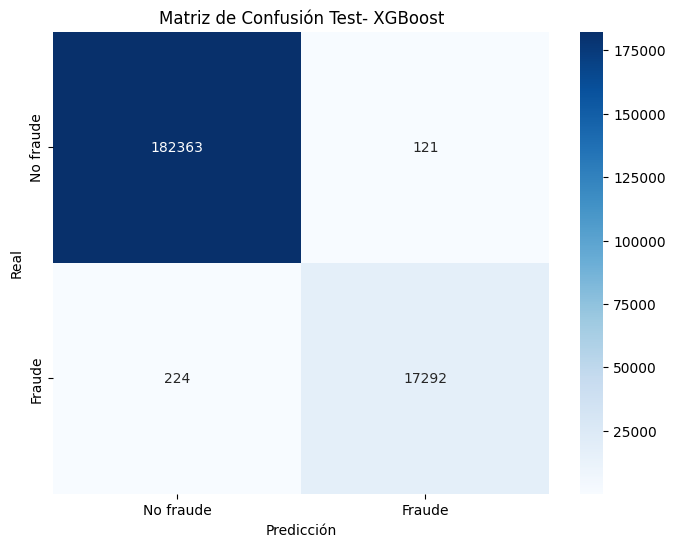

In [29]:
# Matriz de confusión
cm_xgboost = confusion_matrix(y_test, y_pred)
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Blues', xticklabels=["No fraude", "Fraude"], yticklabels=["No fraude", "Fraude"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Test- XGBoost')
plt.savefig("../figures/Matriz_confusion_xgboost_test.png", dpi=300, bbox_inches="tight")
plt.show()

Podemos notar que el modelo tiene un buen desempeño. La exactitud es alta y el recall también es alto, lo que significa que el modelo es capaz de detectar la mayoría de las transacciones fraudulentas.  
Para mejorar el modelo se hará una búsqueda de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo.
### Búsqueda de hiperparámetros con GridSearchCV

In [30]:
# Definir el modelo base
xgb_model = XGBClassifier(random_state=14, eval_metric='logloss')

# Búsqueda en dos etapas
# Primera etapa: parámetros más importantes
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.005],
    'max_depth': [3, 5],
    'scale_pos_weight': [1, 10, 50]  # Mantén todas las opciones aquí
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',  # Métrica de evaluación
    cv=3, 
    verbose=1, 
    n_jobs=-1  # Paralelización
)

In [31]:
# Entrenar el GridSearchCV
grid_search.fit(X_train, y_train)

# Guardar el mejor modelo 
best_model = grid_search.best_estimator_
best_model.save_model("../models/best_xgboost_model.json")

# Mostrar los mejores parámetros y el mejor puntaje
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje (recall):", grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'scale_pos_weight': 50}
Mejor puntaje (recall): 1.0


Exactitud del modelo XGBoost en train: 0.9933
Recall del modelo XGBoost en train: 1.0000
Exactitud del modelo XGBoost en test: 0.9931
Recall del modelo XGBoost: 1.0000


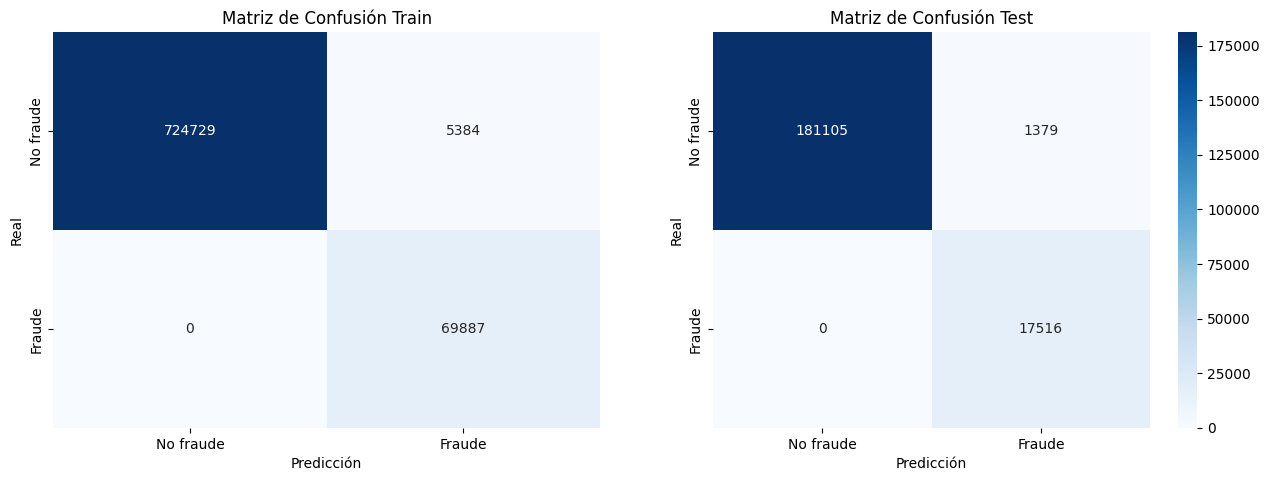

In [32]:
y_pred_train = grid_search.predict(X_train)
# Calcular la exactitud
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Exactitud del modelo XGBoost en train: {accuracy_train:.4f}")
# Calcular el recall
recall_train = recall_score(y_train, y_pred_train)
print(f"Recall del modelo XGBoost en train: {recall_train:.4f}")

y_pred_test = grid_search.predict(X_test)
# Calcular la exactitud
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Exactitud del modelo XGBoost en test: {accuracy_test:.4f}")
# Calcular el recall
recall_test = recall_score(y_test, y_pred_test)
print(f"Recall del modelo XGBoost: {recall_test:.4f}")

# Matriz de confusión
cm_xgboost_train = confusion_matrix(y_train, y_pred_train)
cm_xgboost_test = confusion_matrix(y_test, y_pred_test)

# Visualizar la matriz de confusión
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Increase figure width for better separation
ax[0].set_title('Matriz de Confusión Train')
sns.heatmap(cm_xgboost_train, annot=True, fmt='d', cmap='Blues', xticklabels=["No fraude", "Fraude"], yticklabels=["No fraude", "Fraude"], ax=ax[0], cbar=False)
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Real')

ax[1].set_title('Matriz de Confusión Test')
sns.heatmap(cm_xgboost_test, annot=True, fmt='d', cmap='Blues', xticklabels=["No fraude", "Fraude"], yticklabels=["No fraude", "Fraude"], ax=ax[1])
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Real')

plt.tight_layout(pad=5.0)  

plt.savefig("../figures/Matriz_confusion_xgboost_train_test.png", dpi=300, bbox_inches="tight")
plt.show()

# Conclusiones
Al probar el modelo de autoencoder se notó que no era capaz de distinguir entre las transacciones fraudulentas y no fraudulentas, ya que las distribuciones de los errores eran muy similares.  
El modelo de XGBoost tuvo un mejor desempeño, ya que logró detectar la mayoría de las transacciones fraudulentas y tuvo una buena exactitud, a pesar de el desbalanceo de clases.  
Se usó la búsqueda de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo XGboost y se logró mejorar el desempeño del modelo que ya era bueno  
Podemos concluir que el modelo de XGBoost es una buena opción para la detección de transacciones fraudulentas, ya que es capaz de manejar el desbalanceo de clases y tiene un buen desempeño en general.  
También hay que tener en cuenta que las métricas pueden ser engañosas, ya que el desbalanceo de clases puede afectar la interpretación de los resultados, por lo que es labor del data scientist elegir las métricas y el modelo adecuados para cada caso.